# <span style=color:blue> Concurrent and Parallel Programming in Python</span>
https://docs.python.org/3/library/concurrency.html#concurrent-execution
+ There are two kinds of task 
  + I/O bound: file accesses, network accesses, etc.
  + CPU bound: heavy computing tasks



$\text{}$ | Process | Thread 
---- | --------- | --------
Address space | Separate address space | Common address space
Communication | Inter-process communication | Memory synchronization
System resources | More | fewer
Context switching | Slower | Faster

-----
## <span style=color:blue>Race conditions</span>

A race condition or race hazard is the behavior of an electronics, software, or other system where the output is dependent on the sequence or timing of other uncontrollable events. It becomes a bug when events do not happen in the order the programmer intended.
(WiKi: https://en.wikipedia.org/wiki/Race_condition)
#### Example of a race condition

Threads #1 and #2 modify a global variable _ref_count, and the value of _ref_count  is dependent on the executing sequence of the two threads if there is no proper synchronization (lock). 


## <span style=color:blue>Global Interpreter Lock (GIL)</span>
+ In Python, there are two kinds of tool for concurrent execution of codes.
  + In CPython, thread-based parallelism is suitable for tasks of I/O bound.
  + In CPython, process-based parallelism is suitable for tasks of CPU bound.

### <span style=color:red> In CPython, GIL is used to integrate libraries not thread-safe and true parallelism cannot always be achieved through multithreading.</span>

Python Implementations: https://docs.python-guide.org/starting/which-python/ 
+ CPython (https://www.python.org/)
+ PyPy
+ Jython (Java virtual machine)
+ IronPython, PythonNet (.NET framework)

CPython requires the GIL: https://wiki.python.org/moin/GlobalInterpreterLock

Jython does not require the GIL: http://www.jython.org/jythonbook/en/1.0/Concurrency.html


-----
## <span style=color:blue> Processes vs Threads in Python </span>
<img src="attachment:process_vs_thread.png" width="900">
### <span style=color:red>multiprocessing.Process works normally when running Python interpreter but fails when running Jupyter notebook on Windows 10.</span>
+ Creating a process is slower than creating a thread.
+ In Python (CPython), multithreading is not suitable for tasks of CPU bound.

### Depending on the platform, multiprocessing supports three ways to start a process.
multiprocessing.set_start_method(method_name) 
+ 'spawn' (Available on Unix and Windows. The default on Windows.) 
+ 'fork' (The default on Unix)
+ 'forkserver' (Available on Unix platforms which support passing file descriptors over Unix pipes.)
set_start_method() should not be used more than once in the program. Therefore, set_start_method() should be called in the $if __name__ == '__main__'$ clause of the main module.


    if __name__ == '__main__':
        multiprocessing.set_start_method('spawn')
https://docs.python.org/3/library/multiprocessing.html#contexts-and-start-methods

In [2]:
# -*- coding: utf-8 -*-
import os
import time
import threading
import multiprocessing
import math

# an I/O-bound task
def wait():
    print("PID:{} Process name:{} Thread name:{}".format(os.getpid(),
          multiprocessing.current_process().name,
          threading.current_thread().name))
    time.sleep(1) # sleep one second

# a CPU-bound task
def computing():
    print("PID:{} Process name:{} Thread name:{}".format(os.getpid(),
          multiprocessing.current_process().name,
          threading.current_thread().name))
    x = 0
    y = 0.001
    while x < 10000000:
        y = math.cos(y)
        x = x + 1        
    return y

if __name__=="__main__":
    total_cpu = os.cpu_count()
    
    for func in [wait, computing]:
        print("{} test {} {}".format('-'*10,func.__name__,'-'*10))

        start_time = time.time()
        for _ in range(total_cpu):
            func()
        end_time = time.time()
        print("serial execution: {}".format(end_time-start_time))
        #-------------------------------------------------------------------        
        start_time = time.time()
        threads = [threading.Thread(target=func) for _ in range(total_cpu)]
        for thread in threads:
            thread.start()
    
        for thread in threads:
            thread.join()
        end_time = time.time()
        print("execution time of multithreading: {}".format(end_time-start_time))
        #-------------------------------------------------------------------
        start_time = time.time()
        processes = [multiprocessing.Process(target=func) for _ in range(total_cpu)]
        for process in processes:
            process.start()
        for process in processes:
            process.join()
        end_time = time.time()
        print("execution time of multiprocessing: {}".format(end_time-start_time))


---------- test wait ----------
PID:6420 Process name:MainProcess Thread name:MainThread
PID:6420 Process name:MainProcess Thread name:MainThread
PID:6420 Process name:MainProcess Thread name:MainThread
PID:6420 Process name:MainProcess Thread name:MainThread
PID:6420 Process name:MainProcess Thread name:MainThread
PID:6420 Process name:MainProcess Thread name:MainThread
PID:6420 Process name:MainProcess Thread name:MainThread
PID:6420 Process name:MainProcess Thread name:MainThread
PID:6420 Process name:MainProcess Thread name:MainThread
PID:6420 Process name:MainProcess Thread name:MainThread
PID:6420 Process name:MainProcess Thread name:MainThread
PID:6420 Process name:MainProcess Thread name:MainThread
serial execution: 12.006043672561646
PID:6420 Process name:MainProcess Thread name:Thread-8PID:6420 Process name:MainProcess Thread name:Thread-9

PID:6420 Process name:MainProcess Thread name:Thread-10
PID:6420 Process name:MainProcess Thread name:Thread-11
PID:6420 Process name:Mai

####       
-----
### threading.Thread: create a thread object
    import threading
    athread = threading.Thread(target=f,args=(p1,…),kwargs={k1:v1,…}) 
    
    where args and kwargs are positional and keyword parameters for the function f.
+ The main thread cannot terminate unless all nondaemon threads are terminated.
+ Daemon threads are created by setting the daemon parameter True as threading.Thread(daemon=True). The daemon thread can be kept when the entire program exits.
####  
-----
### Thread Methods
+ Call start() to start a thread.
+ Call join(timeout) to wait at most timeout seconds for the competition of a thread.
+ Call is_alive() to test if the thread is alive.

Reference
https://docs.python.org/2/library/threading.html#thread-objects

### An example of a race condition

In [9]:
import threading

x = 0
def func(v):
    global x
    for i in range(20000000):
        x = v
        if x != x:
            print('thread: {} v: {} x: {}'.format(threading.current_thread().name,v,x))

t1 = threading.Thread(target=func,args=(1,))
t2 = threading.Thread(target=func,args=(2,))
print('some messages will be shown if x!=x')
t1.start()
t2.start()

t1.join()
t2.join()

print('completed')

some messages will be shown if x!=x
thread: Thread-22 v: 1 x: 2
thread: Thread-23 v: 2 x: 1
thread: Thread-23 v: 2 x: 1
thread: Thread-23 v: 2 x: 1
thread: Thread-22 v: 1 x: 2
thread: Thread-23 v: 2 x: 1
thread: Thread-22 v: 1 x: 2
thread: Thread-22 v: 1 x: 2
thread: Thread-22 v: 1 x: 2
thread: Thread-23 v: 2 x: 1
thread: Thread-22 v: 1 x: 2
thread: Thread-22 v: 1 x: 2
thread: Thread-22 v: 1 x: 2
thread: Thread-22 v: 1 x: 2
thread: Thread-23 v: 2 x: 1
thread: Thread-22 v: 1 x: 2
thread: Thread-23 v: 2 x: 1
thread: Thread-23 v: 2 x: 1
thread: Thread-23 v: 2 x: 1
thread: Thread-23 v: 2 x: 1
thread: Thread-22 v: 1 x: 2
thread: Thread-22 v: 1 x: 2
thread: Thread-22 v: 1 x: 2
thread: Thread-23 v: 2 x: 1
thread: Thread-22 v: 1 x: 2
thread: Thread-23 v: 2 x: 1
thread: Thread-22 v: 1 x: 2
completed


### Objects  used to synchronize thread objects.

+ __Lock/RLock__: A lock can be in either “locked” or “unlocked”. 
  + It is created in the unlocked state. 
  + <span style=color:red>acquire()</span> can change the state from unlocked to locked. When the state is locked, acquire() blocks until a call to release() in another thread, then acquire() resets it to locked and returns. 
  + <span style=color:red>release()</span> changes the state to unlocked and returns immediately. If an attempt is made to release an unlocked lock, a ThreadError will be raised.
+ __Condition Objects__
+ __Semaphore Objects__: 
A semaphore has an internal counter which is decremented by each acquire() call and incremented by each release() call. When acquire() finds that this counter is zero, it blocks, and waits until some other thread calls release() of this semaphore.
+ __Event Objects__


Lock, RLock, Condition, and Semaphore objects can be used as with statement context managers.

    lock_object = threading.Lock()
    
    with lock_object:
        # acquire() will be called automatically after entering this block
        ...
        # release() will be called automatically before leaving this block
        
### An example of using threading.Lock to synchronize thread objects.        

In [1]:
import threading

x = 0
def func(v, lock):
    global x
    for i in range(2000000):
        with lock:
            x = v
            if x != x:
                print('thread: {} v: {} x: {}'.format(threading.current_thread().name,v,x))
#        lock.acquire()
#        x = v
#        if x != x:
#            print('thread: {} v: {} x: {}'.format(threading.current_thread().name,v,x))
#
#        lock.release()

lock_object = threading.Lock()
                
t1 = threading.Thread(target=func,args=(1,lock_object))
t2 = threading.Thread(target=func,args=(2,lock_object))

print('some messages can be shown if x!=x')

t1.start()
t2.start()

t1.join()
t2.join()

print('completed')

some messages can be shown if x!=x
completed


####   
-----
### Deadlocks
A deadlock is a state in which some threads/processes wait for each other.
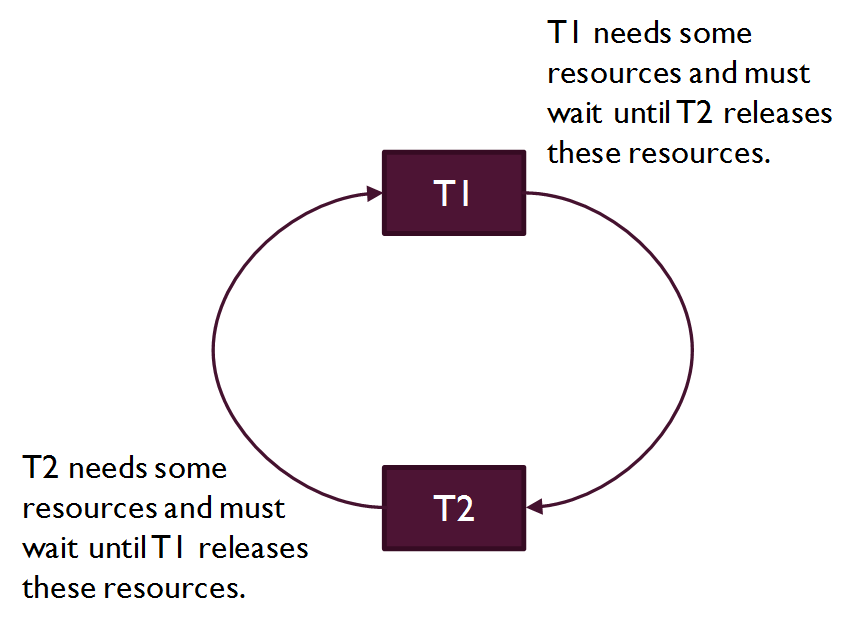

In [12]:
import threading
import time
def func1():
    global t2
    time.sleep(1)
    print('{} waits for {}\n'.format(threading.current_thread().name,t2.name))
    t2.join()
    print('{} completes\n'.format(threading.current_thread().name))
    
def func2():
    global t1
    time.sleep(1)
    print('{} waits for {}\n'.format(threading.current_thread().name,t1.name))
    t1.join()
    print('{} completes\n'.format(threading.current_thread().name))

t1 = threading.Thread(target=func1)
t2 = threading.Thread(target=func2)

t1.start()
t2.start()


print('you cannot see the message "thread-xxx completes"')

you cannot see the message "thread-xxx completes"
Thread-29 waits for Thread-28
Thread-28 waits for Thread-29




----- 
### Timer Objects
Example 1. timer_func will be executed after 5 seconds.

In [11]:
import threading
import time
from datetime import datetime

def timer_func(n):
    print('thread starts:{}'.format(datetime.now()))
    for _ in range(n):
        print('{},hello'.format(threading.current_thread().name))

t = threading.Timer(5, timer_func, (10,))   
print('timer activated:{}'.format(datetime.now()))
t.start()
time.sleep(10)
print(t.is_alive())
t.join()

timer activated:2018-11-09 13:04:01.748624
thread starts:2018-11-09 13:04:06.757735
Thread-17,hello
Thread-17,hello
Thread-17,hello
Thread-17,hello
Thread-17,hello
Thread-17,hello
Thread-17,hello
Thread-17,hello
Thread-17,hello
Thread-17,hello
False


Example 2. The Timer object can be used to call a function for every n seconds.

In [1]:
import threading
import time
from datetime import datetime, timedelta
repeat = 5
def timer_func2(n):
    global repeat
    if repeat > 0:
        t = threading.Timer(n, timer_func2,(n,))
        t.start()
        print('thread {} will start at {}'.format(t.name,datetime.now()+timedelta(seconds=n)))
        repeat -= 1
        
    for _ in range(5): 
        print('{},hello {}'.format(threading.current_thread().name,datetime.now()))
    print('{} leaves timer_func {}'.format(threading.current_thread().name,datetime.now()))
     
t = threading.Timer(2,timer_func2,(2,))
t.start()
for _ in range(20):
    print('The main thread is doing something')
    time.sleep(10)

The main thread is doing something
thread Thread-7 will start at 2018-11-09 14:35:20.674388
Thread-6,hello 2018-11-09 14:35:18.679388
Thread-6,hello 2018-11-09 14:35:18.679388
Thread-6,hello 2018-11-09 14:35:18.679388
Thread-6,hello 2018-11-09 14:35:18.679388
Thread-6,hello 2018-11-09 14:35:18.679388
Thread-6 leaves timer_func 2018-11-09 14:35:18.679388
thread Thread-8 will start at 2018-11-09 14:35:22.686503
Thread-7,hello 2018-11-09 14:35:20.691504
Thread-7,hello 2018-11-09 14:35:20.691504
Thread-7,hello 2018-11-09 14:35:20.691504
Thread-7,hello 2018-11-09 14:35:20.691504
Thread-7,hello 2018-11-09 14:35:20.691504
Thread-7 leaves timer_func 2018-11-09 14:35:20.691504
thread Thread-9 will start at 2018-11-09 14:35:24.698618
Thread-8,hello 2018-11-09 14:35:22.703619
Thread-8,hello 2018-11-09 14:35:22.703619
Thread-8,hello 2018-11-09 14:35:22.703619
Thread-8,hello 2018-11-09 14:35:22.703619
Thread-8,hello 2018-11-09 14:35:22.703619
Thread-8 leaves timer_func 2018-11-09 14:35:22.703619
th

In [1]:
import threading
import time
from datetime import datetime, timedelta
 
def timer_func2(n,event_object):
    while not event_object.isSet():
        print('{},hello {}'.format(threading.current_thread().name,datetime.now()))
        event_object.wait(n)
    print('{} leaves timer_func {}'.format(threading.current_thread().name,datetime.now()))
    
event_object = threading.Event()     
t1 = threading.Timer(2,timer_func2,(2,event_object))
t2 = threading.Timer(2,timer_func2,(2,event_object))
t1.start()
t2.start()
for _ in range(3):
    print('The main thread is doing something')
    time.sleep(5)
event_object.set()
t1.join()
t2.join()

The main thread is doing something
Thread-7,hello 2018-11-26 23:25:59.030114
Thread-6,hello 2018-11-26 23:25:59.030114
Thread-6,hello 2018-11-26 23:26:01.045145Thread-7,hello 2018-11-26 23:26:01.045145

The main thread is doing something
Thread-7,hello 2018-11-26 23:26:03.060470Thread-6,hello 2018-11-26 23:26:03.060470

Thread-6,hello 2018-11-26 23:26:05.060540Thread-7,hello 2018-11-26 23:26:05.060540

The main thread is doing something
Thread-6,hello 2018-11-26 23:26:07.065305Thread-7,hello 2018-11-26 23:26:07.065305

Thread-6,hello 2018-11-26 23:26:09.065971Thread-7,hello 2018-11-26 23:26:09.065971

Thread-7,hello 2018-11-26 23:26:11.079962Thread-6,hello 2018-11-26 23:26:11.079962

Thread-7 leaves timer_func 2018-11-26 23:26:12.045858Thread-6 leaves timer_func 2018-11-26 23:26:12.045858



-----
## multiprocessing.Process: create a process
    import multiprocessing
    aprocess = multiprocessing.Process(target=func,args(p1,…),kwargs={k1:v1,…})
+ Call aprocess.start() to start aprocess.
+ Call aprocess.join(timeout) to wait at most timeout seconds for the competition of aprocess.
+ Use a lock to ensure that only one process is in the critical section.

    lock = multiprocessing.Lock()
    
+ Use queues and pipes to communicate between processes
https://docs.python.org/3/library/multiprocessing.html#exchanging-objects-between-processes


-----
## Pool Objects
<img src="attachment:process_pool.png" width="800">

-----
## Executor Objects
+ The concurrent.futures module provides a high-level interface for multithreading and multiprocessing. https://docs.python.org/3/library/concurrent.futures.html#module-concurrent.futures
+ Executor Objects
   + ThreadPoolExecutor(workers = number_of_workers)
   + ProcessPoolExecutor(workers = number_of_workers)
+ Methods for asynchronous execution
  + submit: the results will be yielded once they are completed.
  + map: the results are yielded in the same order of the data.
  
| submit | map   |
|----|-----|
| 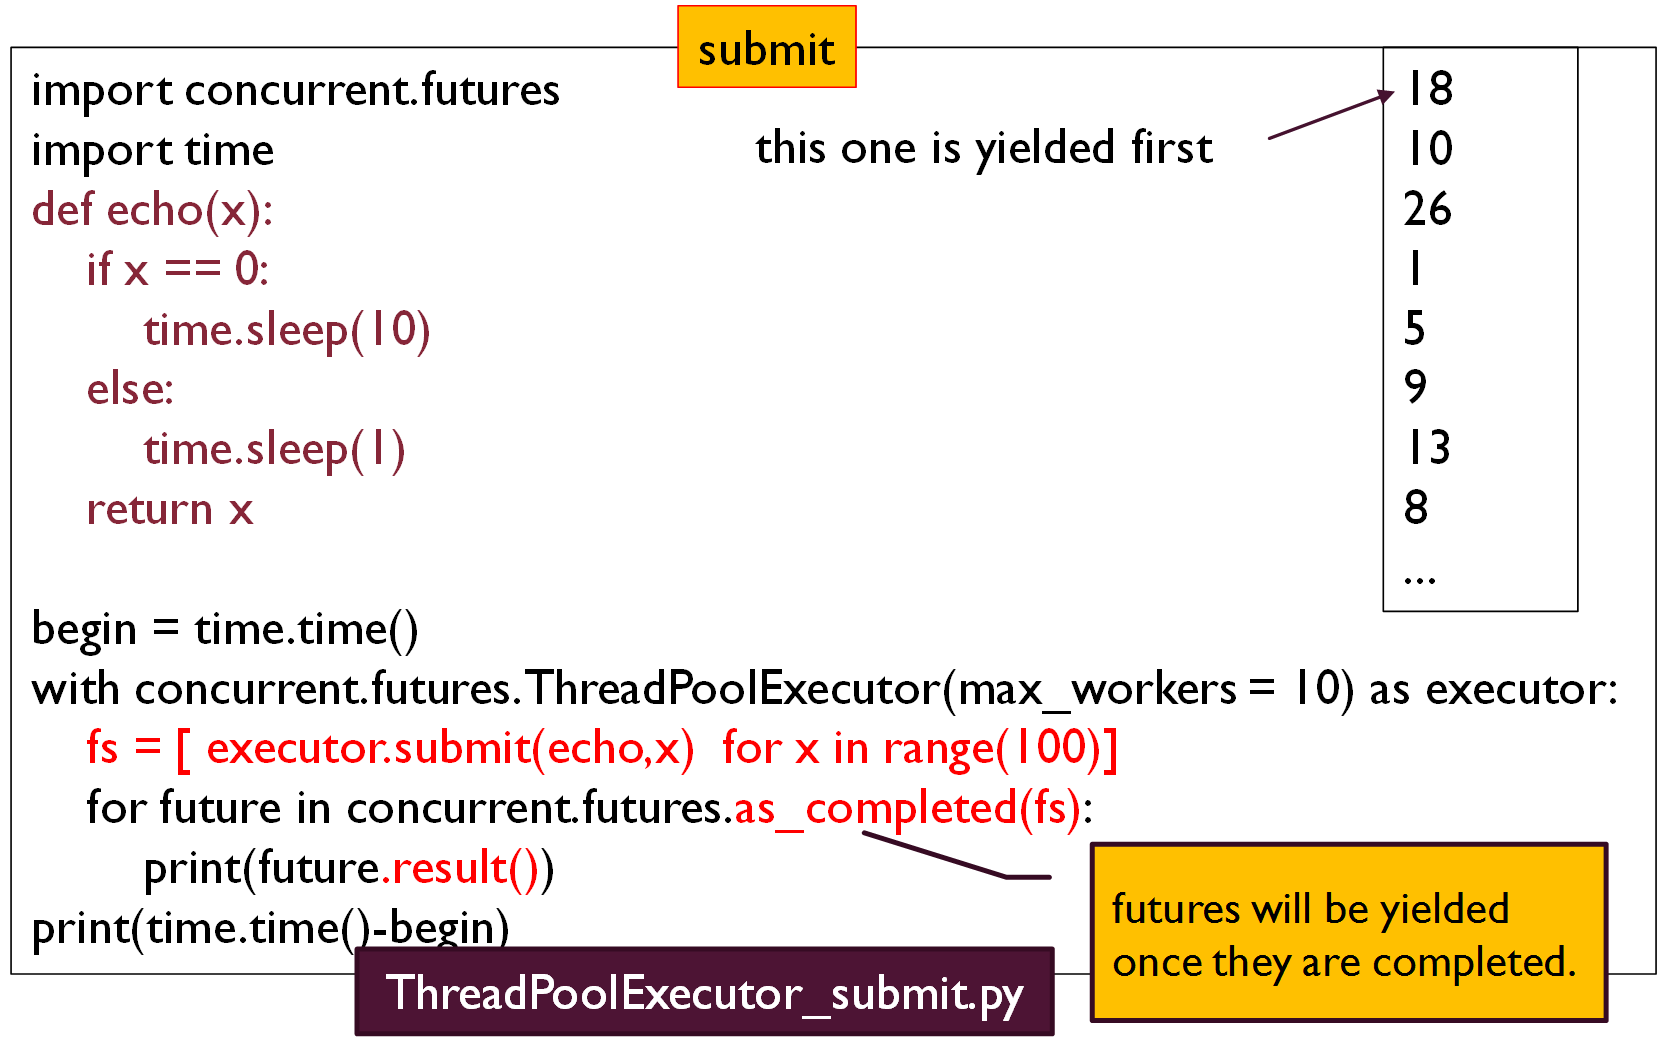| 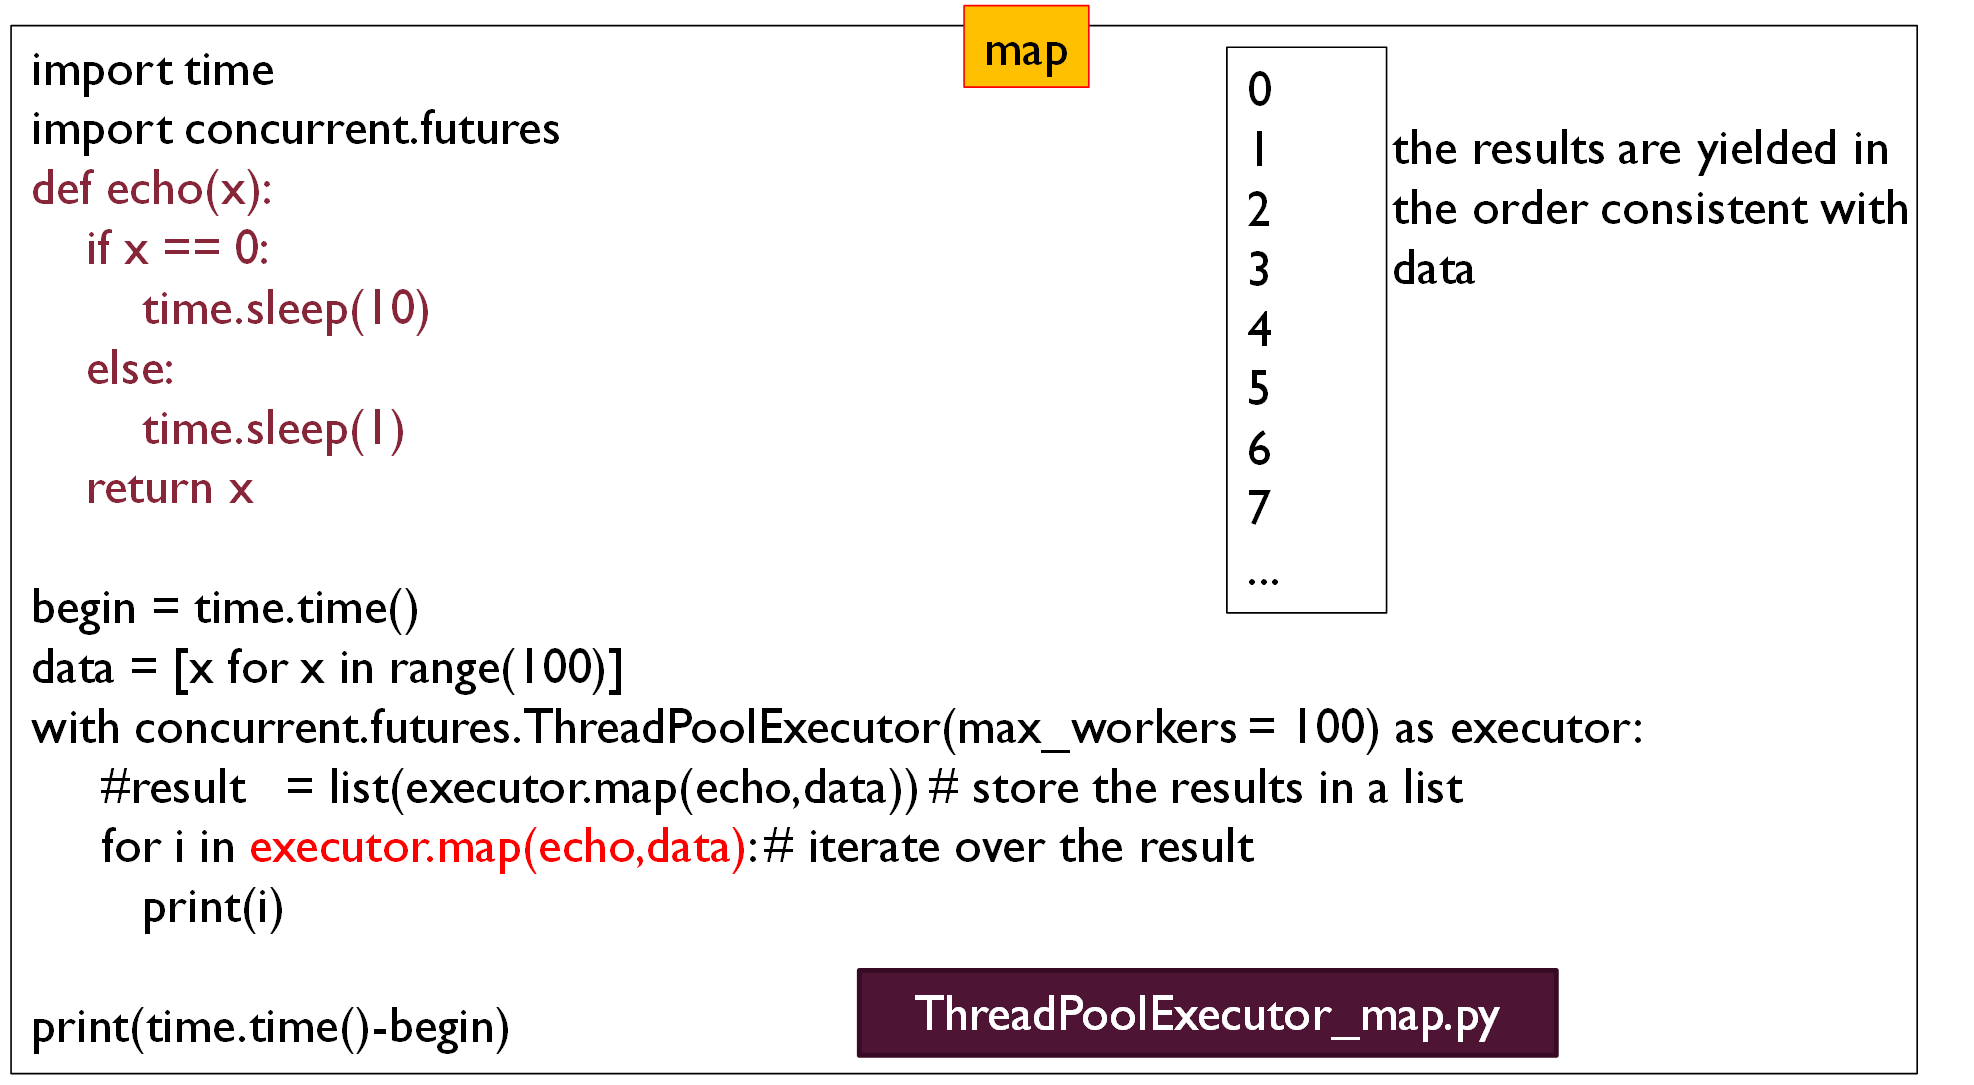|
------
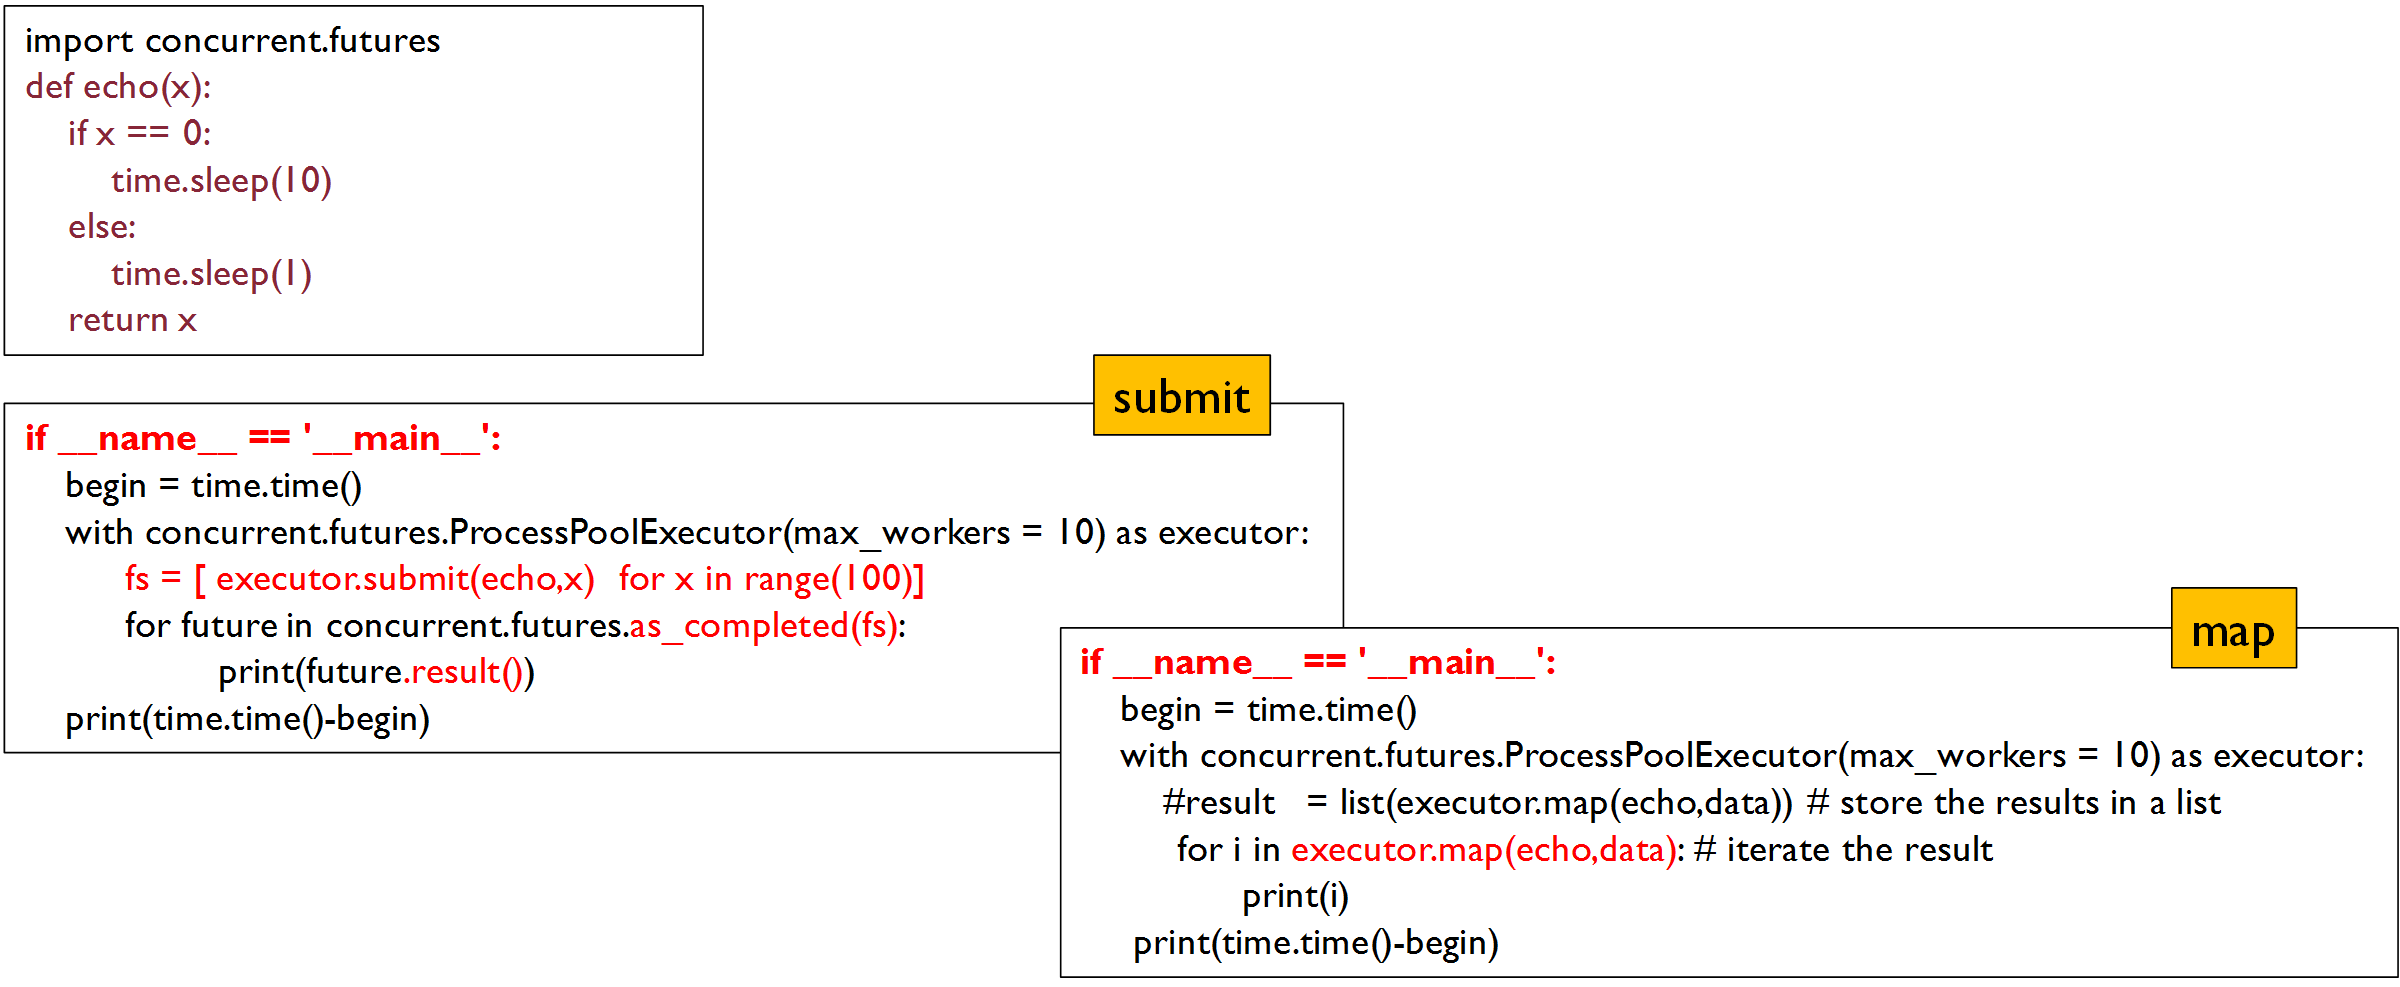


### ProcessPoolExecutor vs ThreadPoolExecutor

In [2]:
import matplotlib.pyplot as plt
import numpy as np
def draw_result(title,workers,result):
    relative_computing_time = result.copy()
    starting_time = min(relative_computing_time[:,0])
    relative_computing_time = relative_computing_time - starting_time    
    plt.barh(y=list(range(1,1+relative_computing_time.shape[0])),width=relative_computing_time[:,1]-relative_computing_time[:,0],left=relative_computing_time[:,0])
    plt.yticks([(i+1)//2 + sum(workers[0:idx]) for idx,i in enumerate(workers)],[str(i) for i in workers])
    plt.title(title)
    plt.xlabel('seconds')
    plt.ylabel('# of threads/processes')
    plt.grid(True)
    print('average computing time {}'.format(np.mean((relative_computing_time[:,1]-relative_computing_time[:,0]).ravel())))
    plt.show()

#### <span style=color:red> ProcessPoolExecutor works on Ubuntu, but fails when running Jupyter notebook on Windows 10</span>
https://stackoverflow.com/questions/43836876/processpoolexecutor-works-on-ubuntu-but-fails-with-brokenprocesspool-when-r

In [3]:
import os
import time
import math
import threading
import multiprocessing
from concurrent.futures import as_completed, ProcessPoolExecutor, ThreadPoolExecutor
import urllib.request
import winprocess

def download(x):
    a = time.time()
    with urllib.request.urlopen('http://python.org/') as response:
        html = response.read()
    b = time.time()
    return [a,b]
    
def computing(x):
    a = time.time()
    x = 0
    y = 0.001
    while x < 5000000:
        y = math.cos(y)
        x = x + 1        
    b = time.time()
    return [a,b]

### CPU bound tasks
+ The average computing time of the multiple threads is 3.68 seconds.
+ The average computing time of the multiple processes is 0.92 seconds.

average computing time 3.6844754830384865


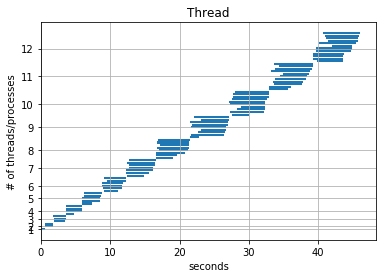

In [4]:
result = []
workers_lst = list(range(1,os.cpu_count()+1))
for workers in workers_lst:
    with ThreadPoolExecutor(max_workers=workers) as executor:
        futures = set()
        for idx in range(workers):
            future = winprocess.submit(
                executor, computing, idx
            )
            futures.add(future)
        
        for future in as_completed(futures):
            result.append(future.result())

draw_result('Thread',workers_lst,np.array(result))

average computing time 0.9212198165746835


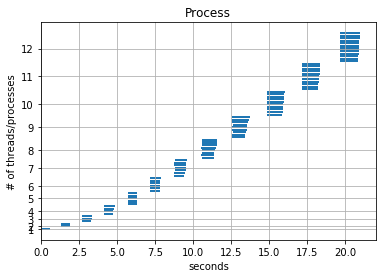

In [5]:
result = []
workers_lst = list(range(1,os.cpu_count()+1))
for workers in workers_lst:
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = set()
        for idx in range(workers):
            future = winprocess.submit(
                executor, computing, idx
            )
            futures.add(future)

        for future in as_completed(futures):
            result.append(future.result())
        
draw_result('Process',workers_lst,np.array(result))        

### I/O bound tasks
+ The average computing time of the multiple threads is 2.21 seconds.
+ The average computing time of the multiple processes is 2.39 seconds.

average computing time 2.2065395544736814


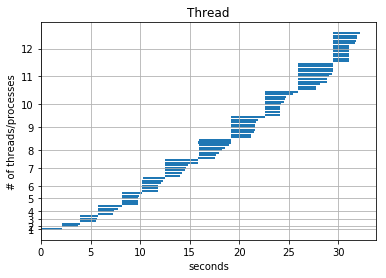

In [6]:
result = []
workers_lst = list(range(1,os.cpu_count()+1))
for workers in workers_lst:
    with ThreadPoolExecutor(max_workers=workers) as executor:
        futures = set()
        for idx in range(workers):
            future = winprocess.submit(
                executor, download, idx
            )
            futures.add(future)
        
        for future in as_completed(futures):
            result.append(future.result())

draw_result('Thread',workers_lst,np.array(result))

average computing time 2.393884866665571


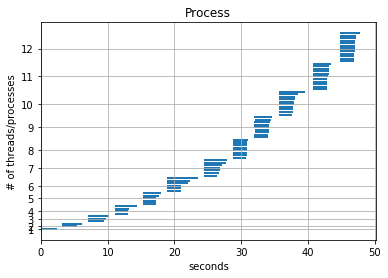

In [7]:
result = []
workers_lst = list(range(1,os.cpu_count()+1))
for workers in workers_lst:
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = set()
        for idx in range(workers):
            future = winprocess.submit(
                executor, download, idx
            )
            futures.add(future)

        for future in as_completed(futures):
            result.append(future.result())
        
draw_result('Process',workers_lst,np.array(result)) 